In [1]:
### Streaming Baseline Using Isolation Forest

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Configuration
DATA_DIR    = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Parameters
SUBSEQ_LEN    = 20
WINDOW_STRIDE = 5
CONTAMINATION = 0.05


In [2]:
# Function to create overlapping windows from the time series
def generate_windows(ts, window_size=SUBSEQ_LEN, stride=WINDOW_STRIDE):
    return np.array([ts[i:i + window_size] for i in range(0, len(ts) - window_size + 1, stride)])

# Run Isolation Forest on streaming data
def run_iforest_stream(ts):
    windows = generate_windows(ts)
    if len(windows) == 0:
        return None, None

    clf = IsolationForest(contamination=CONTAMINATION, random_state=42)
    clf.fit(windows)
    scores = -clf.decision_function(windows)  # higher = more anomalous
    threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
    preds = (scores > threshold).astype(int)

    # Stretch predictions back to full time series length
    stretched_preds = np.zeros(len(ts))
    for i, p in enumerate(preds):
        start = i * WINDOW_STRIDE
        end = start + SUBSEQ_LEN
        stretched_preds[start:end] += p

    # Normalize and threshold
    stretched_preds = (stretched_preds >= 1).astype(int)
    return stretched_preds, np.interp(np.arange(len(ts)), np.arange(0, len(ts) - SUBSEQ_LEN + 1, WINDOW_STRIDE), scores)



Processing normality_1_daphnet.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.439


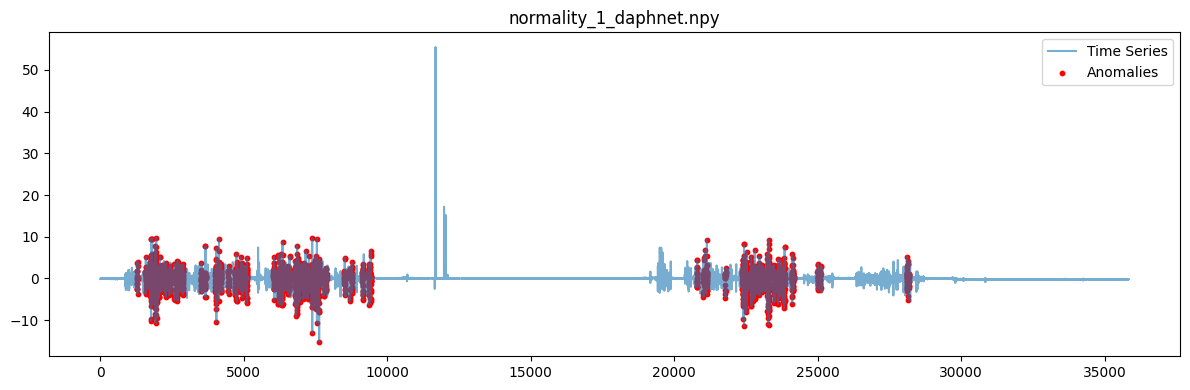


Processing normality_1_genesis.npy
Precision: 0.046, Recall: 0.117, F1: 0.066, AUC: 0.494


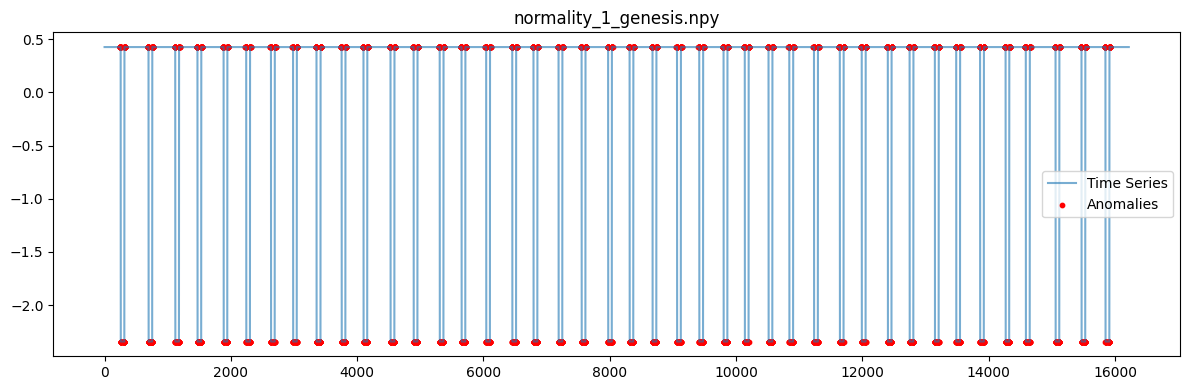


Processing normality_1_nasa-msl.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.445


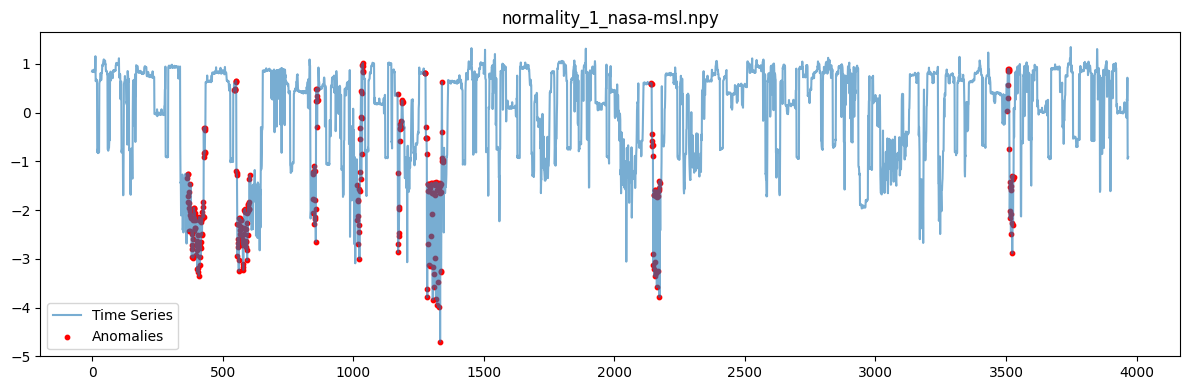


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.344


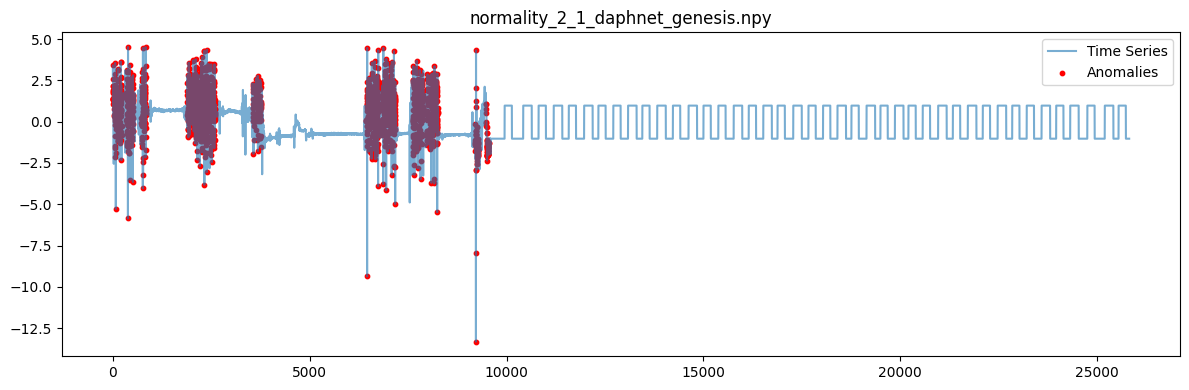


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.019, Recall: 0.030, F1: 0.023, AUC: 0.170


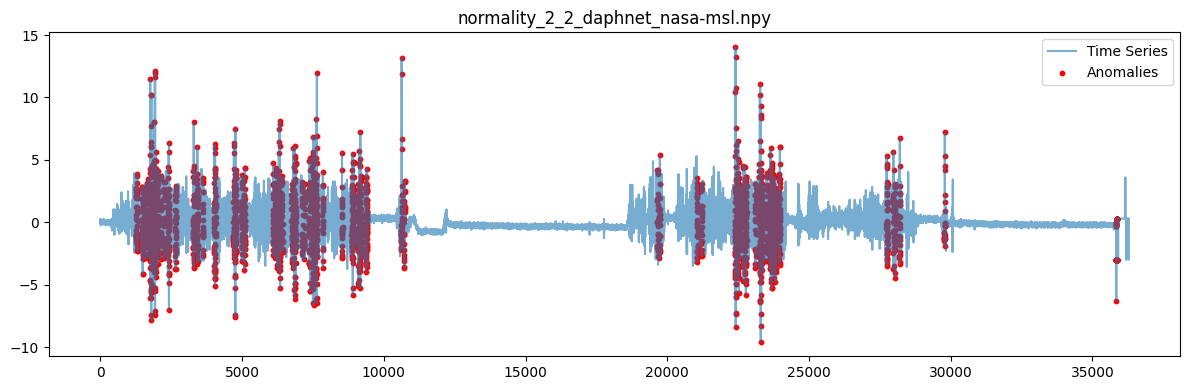


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.039


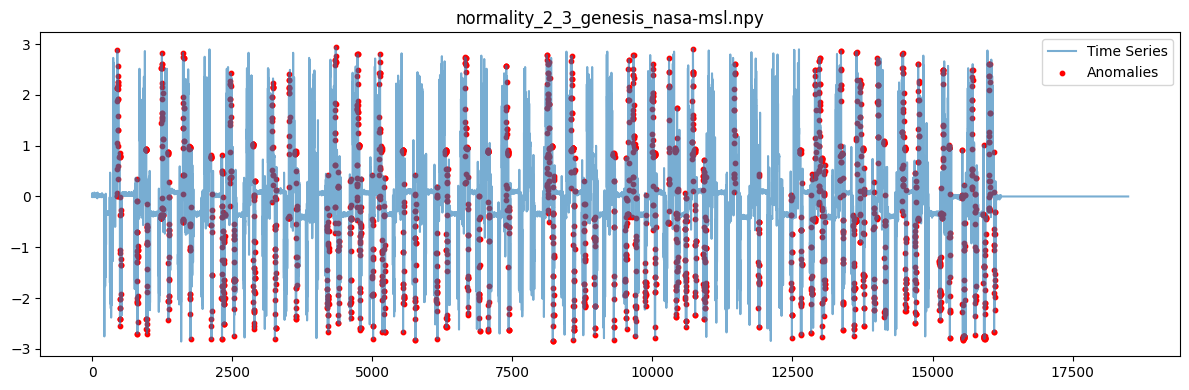


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.051, Recall: 0.083, F1: 0.063, AUC: 0.684


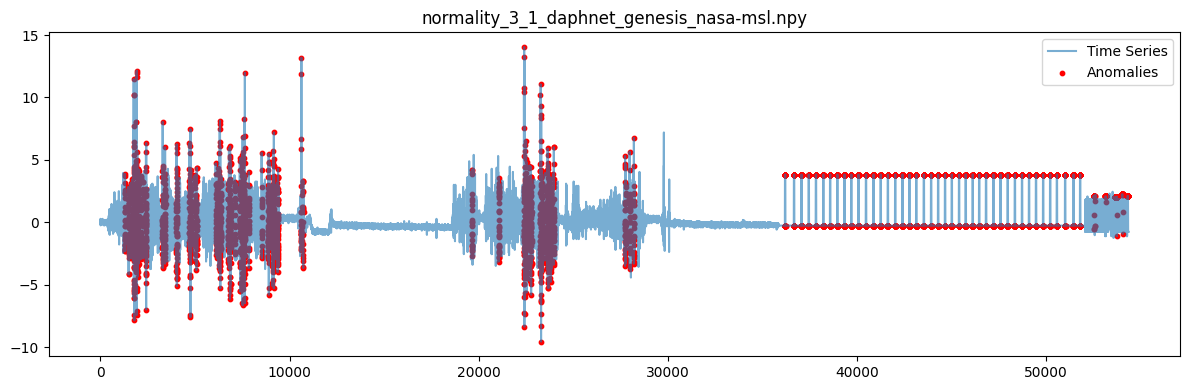


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.140


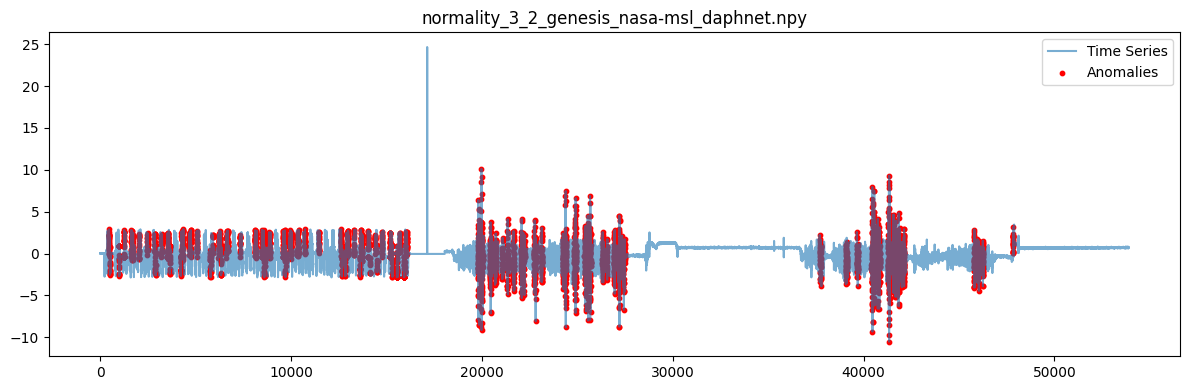


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.313


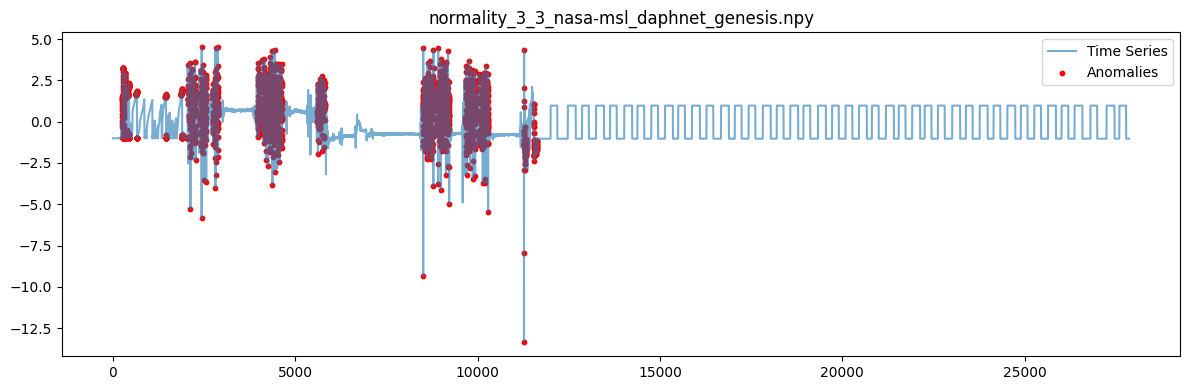

In [3]:
# Loop through all datasets
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts = np.load(os.path.join(DATA_DIR, fname))

    preds, scores = run_iforest_stream(ts)
    if preds is None or scores is None:
        print("Skipped: Failed to process")
        continue

    labels = np.zeros(len(scores))
    labels[-int(len(scores) * CONTAMINATION):] = 1

    p = precision_score(labels, preds, zero_division=0)
    r = recall_score(labels, preds, zero_division=0)
    f = f1_score(labels, preds, zero_division=0)
    a = roc_auc_score(labels, scores) if len(set(labels)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}")

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(ts, label="Time Series", alpha=0.6)
    anomaly_idxs = np.where(preds == 1)[0]
    plt.scatter(anomaly_idxs, ts[anomaly_idxs], color='red', s=10, label="Anomalies")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.show()

    summary.append(dict(dataset=fname, length=len(ts),
                        precision=round(p, 3),
                        recall=round(r, 3),
                        f1=round(f, 3),
                        auc=round(a, 3)))

In [4]:
# Save summary
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "iforest_streaming_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc
dataset,,,,,
normality_1_daphnet.npy,35840,0.000,0.000,0.000,0.439
normality_1_genesis.npy,16220,0.046,0.117,0.066,0.494
normality_1_nasa-msl.npy,3969,0.000,0.000,0.000,0.445
normality_2_1_daphnet_genesis.npy,25820,0.000,0.000,0.000,0.344
normality_2_2_daphnet_nasa-msl.npy,36279,0.019,0.030,0.023,0.170
normality_2_3_genesis_nasa-msl.npy,18492,0.000,0.000,0.000,0.039
normality_3_1_daphnet_genesis_nasa-msl.npy,54363,0.051,0.083,0.063,0.684
normality_3_2_genesis_nasa-msl_daphnet.npy,53887,0.000,0.000,0.000,0.140
normality_3_3_nasa-msl_daphnet_genesis.npy,27871,0.000,0.000,0.000,0.313
